# Project 2 - Part 2

- Finish fine-tuning of Transformer transfer learning model
- implement encoding model 

Maybe look at: https://github.com/jefflai108/Contrastive-Predictive-Coding-PyTorch

In [1]:
pip install -r requirements.txt

ERROR: Ignored the following versions that require a different python version: 8.19.0 Requires-Python >=3.10; 8.20.0 Requires-Python >=3.10; 8.21.0 Requires-Python >=3.10; 8.22.0 Requires-Python >=3.10; 8.22.1 Requires-Python >=3.10; 8.22.2 Requires-Python >=3.10; 8.23.0 Requires-Python >=3.10; 8.24.0 Requires-Python >=3.10
ERROR: Could not find a version that satisfies the requirement ipython==8.24.0 (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 7.4.0, 7.5.0, 7.6.0, 7.6.1, 7.7.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import math
import umap.umap_ as umap
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
import random
import pickle

In [3]:
data_train = pd.read_csv('data/mitbih_train.csv')
data_test = pd.read_csv('data/mitbih_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns) - 1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns) - 1)] + ['label']

X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:, -1]

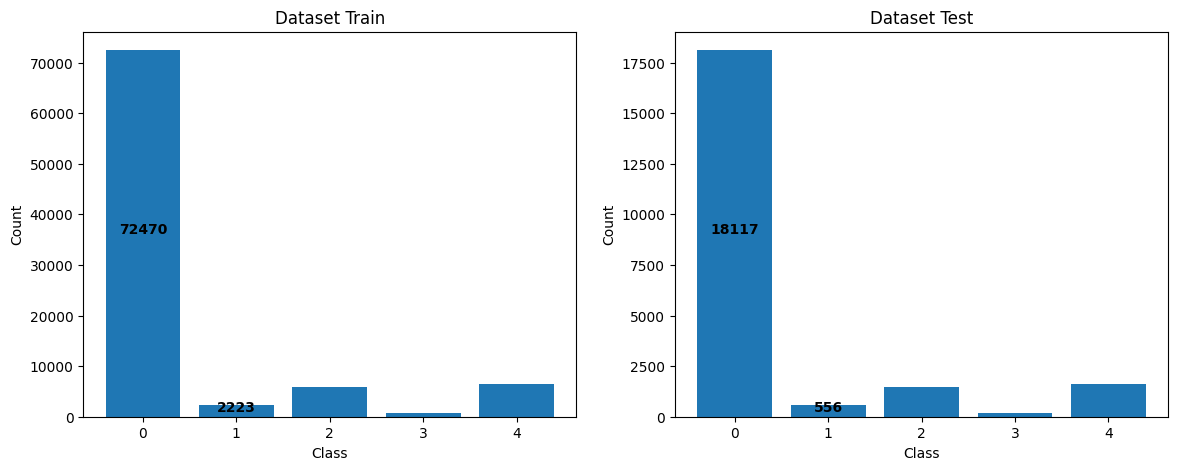

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

datasets = [y_train, y_test]
dataset_names = ['Train', 'Test']
for i in range(2):
    axs[i].bar(np.unique(y_train), datasets[i].value_counts().sort_index(ascending=True))
    axs[i].set_title('Dataset ' + dataset_names[i])
    axs[i].set_ylabel('Count')
    axs[i].set_xlabel('Class')
    axs[i].text(0, datasets[i].value_counts()[0] / 2, datasets[i].value_counts()[0], ha='center', fontweight='bold')
    axs[i].text(1, datasets[i].value_counts()[1] / 2, datasets[i].value_counts()[1], ha='center', fontweight='bold')
plt.show()


## Data preparation

In [5]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [6]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(2).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [7]:
X_train_dataloader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor), batch_size=100,
                                shuffle=True)
X_test_dataloader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor), batch_size=100,
                               shuffle=False)

## Supervised Model for Transfer

In [8]:
## Use balanced accuracy as metric
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_size, d_model=128, nhead=4, num_encoder_layers=3, dim_feedforward=512,
                 dropout=0.1, max_k=20):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.fc1 = nn.Linear(d_model, d_model)
        self.fc2 = nn.Linear(d_model, output_size)
        self.d_model = d_model

        self.W = nn.Parameter(torch.randn(max_k, d_model, d_model))
        self.z_encoder = nn.Linear(1, d_model)

    def encode(self, src):
        src = self.embedding(src.permute(0, 2, 1)) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return self.fc1(output.mean(dim=1))  # Global average pooling

    def forward(self, src):
        output = self.encode(src)
        output = nn.functional.relu(output)
        output = self.fc2(output)
        # CrossEntropyLoss does not need any activation function in the output layer
        return output

input_size = X_train_tensor.shape[1]
output_size = len(np.unique(y_train))

In [350]:
def train_model(model, model_name, criterion, optimizer, X_train_dataloader, X_test_tensor, y_test_tensor, num_epochs, truncate, ret_weights=False):
    epoch_losses_training = []
    epoch_losses_testing = []
    epoch_accuracies_training = []
    epoch_accuracies_testing = []

    best_test_accuracy = 0

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0
        pred_train = []
        y_train_list = []

        for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]

            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            
        
            pred_train.append(torch.argmax(outputs, dim=1))
            y_train_list.append(y_batch)

            total_loss += loss.item() * len(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_accuracies_training.append(
            balanced_accuracy_score(torch.cat(y_train_list).cpu().numpy(), torch.cat(pred_train).cpu().numpy()))
        epoch_losses_training.append(total_loss / len(X_train_tensor))

        with torch.no_grad():

            pred_test = []
            y_test_list = []

            for i, (X_batch, y_batch) in enumerate(X_test_dataloader):

                if ret_weights:
                    outputs, _ = model(X_batch)
                else:
                    outputs = model(X_batch)

                loss = criterion(outputs, y_batch)
                pred_test.append(torch.argmax(outputs, dim=1))
                y_test_list.append(y_batch)

                total_loss += loss.item() * len(X_batch)

            epoch_accuracies_testing.append(
                balanced_accuracy_score(torch.cat(y_test_list).cpu().numpy(), torch.cat(pred_test).cpu().numpy()))
            epoch_losses_testing.append(total_loss / len(X_test_tensor))

            pbar.set_description(
                f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, Test Loss: {epoch_losses_testing[-1]:.4f}, Test Balanced Accuracy: {epoch_accuracies_testing[-1]:.4f}')

            if epoch_accuracies_testing[-1] > best_test_accuracy:
                best_test_accuracy = epoch_accuracies_testing[-1]
                torch.save(model.state_dict(), f'./p2/models/{model_name}_{num_epochs}_best.pth')

            with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
                pickle.dump(
                    (epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing),
                    f)
    torch.save(model.state_dict(), f'./p2/models/{model_name}_{num_epochs}_final.pth')

In [10]:
def plot_acc_and_loss(model_name, num_epochs):
    with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', "rb") as f:
        while True:
            try:
                epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing = pickle.load(
                    f)
            except EOFError:
                break

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plotting the losses
    axs[0].plot(epoch_losses_training, label='Training Loss')
    axs[0].plot(epoch_losses_testing, label='Testing Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plotting the accuracies
    axs[1].plot(epoch_accuracies_training, label='Training Balanced Accuracy')
    axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [11]:
def print_model_summary(model, criterion, X_test_dataloader, ret_weights=False):
    print(model)
    print('Number of parameters: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

    with torch.no_grad():
        acc_test = []
        test_outputs = []
        total_loss_test = 0
        for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
            outputs = transformer(X_batch)
            loss = criterion(outputs, y_batch)
            pred = torch.argmax(outputs, dim=1)
            acc_test.append(pred == y_batch)
            test_outputs.append(pred)

            total_loss_test += loss.item() * len(X_batch)

    print(
        f'Accuracy: {torch.cat(acc_test).cpu().float().mean():.4f}, Balanced Accuracy: {balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), torch.cat(test_outputs).cpu().numpy()):.4f}, Loss: {total_loss_test / len(X_test_tensor)}, ')

In [12]:
transformer = TransformerModel(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=3e-4)

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [13]:
num_epochs = 100
model_name = 'transformer_mit'
train_model(transformer, model_name, criterion, optimizer, X_train_dataloader, X_test_tensor, y_test_tensor,
            num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [100/100], Loss: 0.0213, Balanced Accuracy: 0.9475, Test Loss: 0.2287, Test Balanced Accuracy: 0.7881: 100%|██████████| 100/100 [28:29<00:00, 17.09s/it]


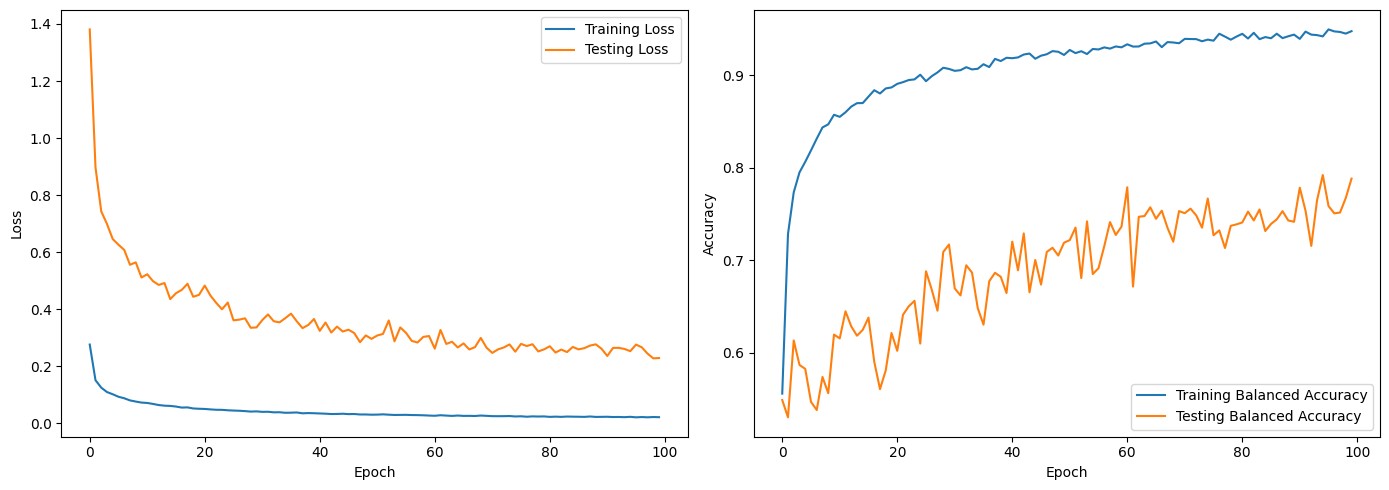

In [14]:
plot_acc_and_loss("transformer_mit", num_epochs)

In [16]:
transformer.load_state_dict(torch.load(f'./p2/models/{model_name}_{num_epochs}_final.pth'))
print_model_summary(transformer, criterion, X_test_dataloader)

TransformerModel(
  (embedding): Linear(in_features=187, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, 

## Representation Learning Model

In [27]:
class CPCAutoregressive(nn.Module):
    def __init__(self, d_model, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(d_model, hidden_dim, batch_first=True)

    def forward(self, z):
        _, hidden = self.gru(z)
        c = hidden.squeeze(0)
        return c

class CPCPredictor(nn.Module):
    def __init__(self, hidden_dim, d_model):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, d_model)
        self.relu = nn.ReLU()

    def forward(self, c):
        output = self.linear(c)
        output = self.relu(output)
        return output

class CPC(nn.Module):
    def __init__(self, input_size, d_model=3, hidden_dim=265, max_k=7):
        super().__init__()
        self.encoder = TransformerModel(input_size, d_model).to(device)
        self.ar_model = CPCAutoregressive(d_model, hidden_dim).to(device)
        self.predictors = [CPCPredictor(hidden_dim, d_model).to(device) for _ in range(max_k)]
        self.lsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        batch = x.shape[0]
        nce = 0
        # Split the input into 17 chunks of length 11 (17 timesteps in total)
        x_ts = []
        for i in range(0, 187, 11):
            x_ts.append(x[:, i:i + 11, :])

        # compute the encodings for each timestep
        z_ts = torch.stack([self.encoder(x) for x in x_ts])
        z_ts = z_ts.permute(1, 0, 2)

        # compute the context for the last timestep (1-10)
        c_t = self.ar_model(z_ts[:, :10, :])

        # compute the predictions for each timestep (11-17)
        z_ts_pred = []
        for i in range(max_k):
            pred = self.predictors[i](c_t)
            z_ts_pred.append(pred)
            nce += torch.sum(torch.diag(self.lsoftmax(torch.matmul(pred, z_ts[:, 10 + i, :].permute(1, 0)))))

        #z_ts_pred = torch.stack(z_ts_pred)
        #z_ts_pred = torch.stack([self.predictors[i](c_t) for i in range(max_k)])
        #z_ts_pred = z_ts_pred.permute(1, 0, 2)
        #return z_ts[:,10:,:], z_ts_pred
        nce /= -1. * batch * max_k
        return nce

    def encode(self, x):
        # Split the input into 17 chunks of length 11 (17 timesteps in total)
        batch = x.shape[0]
        x_ts = []
        for i in range(0, 187, 11):
            x_ts.append(x[:,i:i + 11, :])
        
        z_ts = torch.stack([self.encoder(x) for x in x_ts])
        encoding = z_ts.permute(1, 0, 2).reshape(batch, -1)
        return encoding

In [28]:
def collate_fn(batch):
    X = torch.cat([item[0].unsqueeze(0) for item in batch], dim=0).squeeze(2)

    seq_lens = (X != 0).sum(dim=1)
    min_seq_len = seq_lens.min().item()

    # how many steps into the future I want to predict
    k = torch.randint(1, min(max_k, min_seq_len), (1,)).item()

    t = [torch.randint(0, seq_len - k, (1,)).item() for seq_len in seq_lens]

    # create positive samples y, a target vector that is value t + k for each sequence
    y_pos = torch.tensor([X[i, t[i] + k] for i in range(len(t))])

    # create negative samples by sampling at random from the same sequence
    # I haven't found any resource on how exactly to sample negative samples
    y_neg = torch.zeros(len(batch), num_negative)
    for i in range(len(t)):
        # sample 10 numbers that are not i in the range 0 to len(batch)
        neg_samples = random.sample(range(0, len(batch) - 1), num_negative)
        # remove possibility of sampling i
        neg_samples = torch.tensor([x if x < i else x + 1 for x in neg_samples])

        y_neg[i, :] = y_pos[neg_samples]

    # mask X to only keep the first t elements for each row
    for i in range(len(X)):
        X[i, t[i]:] = 0

    return X.unsqueeze(2).to(device), y_pos.to(device), y_neg.to(device), k

In [280]:
class CPC(nn.Module):
    def __init__(self,
                 input_size = 187,
                 d_model = 10,
                 lstm_features = 5,
                 tau = [1,2,4,8, 16, 32, 64],
                 normalize = False
                ):
        
        super(CPC, self).__init__()
        
        self.encoder = TransformerModel(input_size, d_model).to(device)
        self.recurrent = nn.LSTM(d_model ,lstm_features,batch_first = True)
        
        self.InfoNCE = batch_time_InfoNCE_loss(lstm_features, d_model, normalize = normalize, tau = tau)

    def encode(self,X):
        #X - [batch, 1, time]
        
        Y = self.encoder(X)
        Y = Y.unsqueeze(1)
        C,_ = self.recurrent(Y)
        return C,Y
    
    def forward(self,X):
        self.recurrent.flatten_parameters()
        C,Y = self.encode(X)
        return torch.stack(self.InfoNCE(C,Y))
        
class batch_time_InfoNCE_loss(nn.Module):
    def __init__(self,context_size, encoding_size, normalize = False, tau = [1]):
        super(batch_time_InfoNCE_loss,self).__init__()
        self.InfoNCE = nn.ModuleList([multi_batch_InfoNCE_loss(context_size, encoding_size, normalize) for t in tau])
        self.tau = tau

    def forward(self,C,X):
        ###these both have shape [batch, time, features]
        ###I need to compute 
        return [I(C[:,:-t], X[:,t:]) for I,t in zip(self.InfoNCE,self.tau)]
        
class multi_batch_InfoNCE_loss(nn.Module):
    def __init__(self,context_size, encoding_size, normalize = False):
        super(multi_batch_InfoNCE_loss,self).__init__()
        self.transform = nn.Linear(encoding_size, context_size)
        self.normalize = normalize
        
    def forward(self,C,X):
        '''
        C - [batch, T, fc]
        X - [batch, T, fx]
        '''
        #I need to compute C.T.X and C.T.X~ where X~ means permuted across all bathces.
        #If I make a tensor which is dim. Z = [batch, batch, time - dt] where the (i,j) comp. is the combination of the (i,j) batch then I can compute:
        # sum_i[Z_ii - log(exp(sum(Z_i)))]
        Xt = self.transform(X)#[batch, fc]

        Z = torch.sum(C.unsqueeze(1)*Xt.unsqueeze(0),-1)#Z - [batch,batch]
        
        if self.normalize:
            Z = Z / (EPS + torch.sqrt(torch.sum(Z**2,-1,keepdims = True)))

        Zmax,_ = torch.max(Z,1,keepdims = True)
        Zdiag = torch.diagonal(Z).transpose(0,1)
        OUT = Zdiag - (torch.log(torch.sum(torch.exp(Z - Zmax),1)) + Zmax[:,0])   

        return torch.mean(OUT)

In [281]:
batch_size = 32
seq_len = 100
input_dim = 11  # e.g. 5 sensors
max_k = 7
num_negative = 10
model_name = 'cpc_mit'

#cpc = CPC(input_dim).to(device)
cpc = CPC().to(device)
optimizer = torch.optim.Adam(cpc.parameters())

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [282]:
#train_dataloader_nce = DataLoader(torch.utils.data.TensorDataset(X_train_tensor[:-1]), batch_size=32, collate_fn=collate_fn, shuffle=True)

In [283]:
num_epochs = 100

pbar = tqdm(range(num_epochs))
epoch_losses_training = []
best_loss = 0

for epoch in pbar:
    total_loss = 0
    pred_train = []
    y_train_list = []

    for i, (X_batch, _) in enumerate(X_train_dataloader):
        loss = cpc(X_batch)
        loss = torch.mean(loss)
    
        total_loss += loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_losses_training.append(total_loss / len(X_train_tensor))

    with torch.no_grad():
        pbar.set_description(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {epoch_losses_training[-1]:.4f}')
        
    if epoch_losses_training[-1] > best_loss:
                best_test_accuracy = epoch_losses_training[-1]
                torch.save(cpc.state_dict(), f'./p2/models/{model_name}_{num_epochs}_best.pth')

    with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
        pickle.dump(epoch_losses_training,f)
        
torch.save(cpc.state_dict(), f'./p2/models/{model_name}_{num_epochs}_final.pth')

Epoch [100/100], training loss: 0.0041: 100%|██████████| 100/100 [25:30<00:00, 15.30s/it]


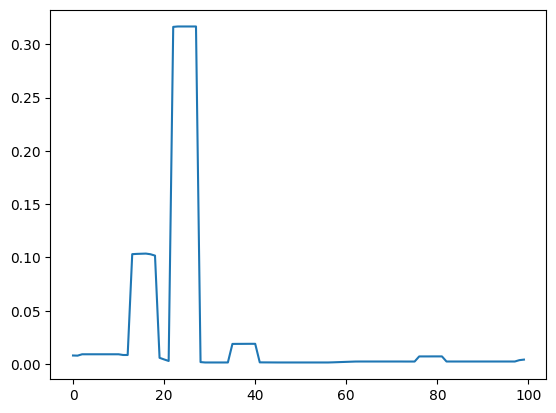

In [284]:
with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'rb') as f:
    epoch_losses_training = torch.stack(pickle.load(f)).detach().cpu().numpy()
 
plt.plot(epoch_losses_training, label='Training Loss')
plt.show()

In [285]:
#num_epochs = 10
cpc.load_state_dict(torch.load(f'./p2/models/{model_name}_{num_epochs}_best.pth'))

<All keys matched successfully>

In [286]:
X_train_cpc_mit = []
y_train_cpc_mit = []

X_test_cpc_mit = []
y_test_cpc_mit = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs, _ = cpc.encode(X_batch)
        X_train_cpc_mit.append(outputs)
        y_train_cpc_mit.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs, _ = cpc.encode(X_batch)
        X_test_cpc_mit.append(outputs)
        y_test_cpc_mit.append(y_batch)

X_train_cpc_mit = torch.cat(X_train_cpc_mit).cpu().numpy().squeeze()
X_test_cpc_mit = torch.cat(X_test_cpc_mit).cpu().numpy().squeeze()

y_train_cpc_mit = torch.cat(y_train_cpc_mit).cpu().numpy().squeeze()
y_test_cpc_mit = torch.cat(y_test_cpc_mit).cpu().numpy().squeeze()

In [287]:
classifier = RandomForestClassifier()
classifier.fit(X_train_cpc_mit, y_train_cpc_mit)
y_pred = classifier.predict(X_test_cpc_mit)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_cpc_mit, y_pred):.4f}')

Test set balanced accuracy: 0.2047


## Visualising Learned Representations

In [288]:
def visualize_umap(X_train_umap, y_train):

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for i in np.unique(y_train):
        ax.scatter(X_train_umap[y_train == i, 0], X_train_umap[y_train == i, 1], label=f'Class {i}')

### Transformer from Q1

In [289]:
transformer = TransformerModel(input_size, output_size).to(device)
transformer.load_state_dict(torch.load('./p2/models/transformer_mit_100_final.pth'))

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

#### MIT data

In [290]:
X_train_transformer_mit = []
y_train_transformer_mit = []

X_test_transformer_mit = []
y_test_transformer_mit = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs = transformer.encode(X_batch)
        X_train_transformer_mit.append(outputs)
        y_train_transformer_mit.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs = transformer.encode(X_batch)
        X_test_transformer_mit.append(outputs)
        y_test_transformer_mit.append(y_batch)

X_train_transformer_mit = torch.cat(X_train_transformer_mit).cpu().numpy()
X_test_transformer_mit = torch.cat(X_test_transformer_mit).cpu().numpy()

y_train_transformer_mit = torch.cat(y_train_transformer_mit).cpu().numpy()
y_test_transformer_mit = torch.cat(y_test_transformer_mit).cpu().numpy()

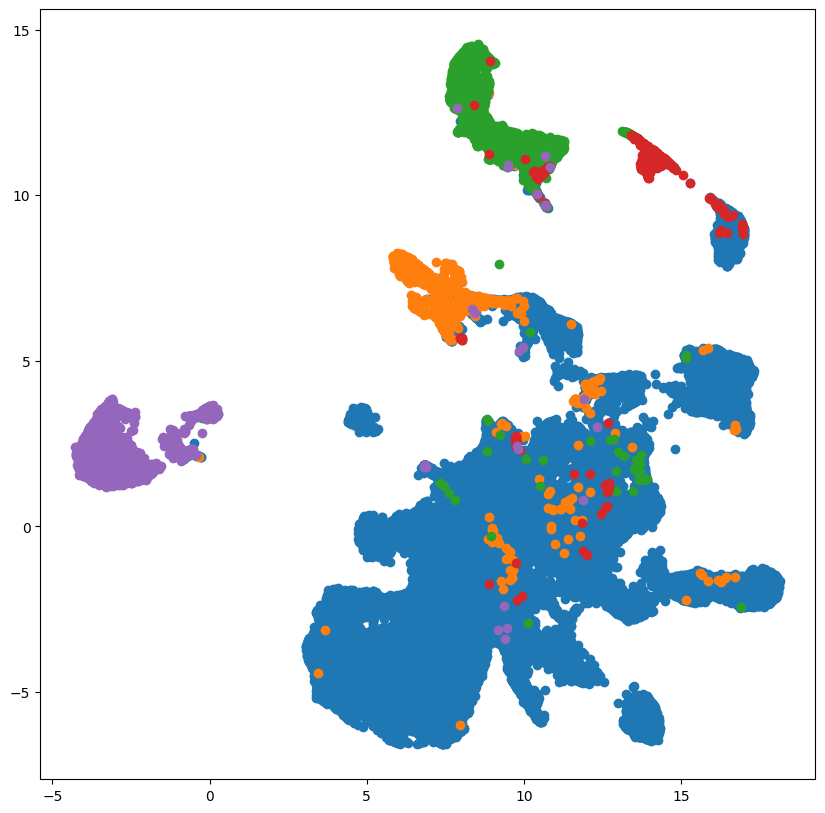

In [291]:
reducer = umap.UMAP(n_components=2)
X_train_umap = reducer.fit_transform(X_train_transformer_mit)
visualize_umap(X_train_umap, y_train_transformer_mit)

#### PTB data

In [292]:
data_train = pd.read_csv('data/ptbdb_train.csv')
data_test = pd.read_csv('data/ptbdb_test.csv')
data_train.columns = [str(i) for i in range(len(data_train.columns) - 1)] + ['label']
data_test.columns = [str(i) for i in range(len(data_test.columns) - 1)] + ['label']

X_train_ptb = data_train.iloc[:, :-1]
y_train_ptb = data_train.iloc[:, -1]
X_test_ptb = data_test.iloc[:, :-1]
y_test_ptb = data_test.iloc[:, -1]

X_train_tensor_ptb = torch.tensor(X_train_ptb.values, dtype=torch.float32).unsqueeze(2).to(device)
y_train_tensor_ptb = torch.tensor(y_train_ptb.values, dtype=torch.float32).to(device)
X_test_tensor_ptb = torch.tensor(X_test_ptb.values, dtype=torch.float32).unsqueeze(2).to(device)
y_test_tensor_ptb = torch.tensor(y_test_ptb.values, dtype=torch.float32).to(device)

X_train_dataloader_ptb = DataLoader(torch.utils.data.TensorDataset(X_train_tensor_ptb, y_train_tensor_ptb),
                                    batch_size=100, shuffle=True)
X_test_dataloader_ptb = DataLoader(torch.utils.data.TensorDataset(X_test_tensor_ptb, y_test_tensor_ptb), batch_size=100,
                                   shuffle=False)

In [293]:
X_train_transformer_ptb = []
y_train_transformer_ptb = []
X_test_transformer_ptb = []
y_test_transformer_ptb = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader_ptb):
        outputs = transformer.encode(X_batch)
        X_train_transformer_ptb.append(outputs)
        y_train_transformer_ptb.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader_ptb):
        outputs = transformer.encode(X_batch)
        X_test_transformer_ptb.append(outputs)
        y_test_transformer_ptb.append(y_batch)

X_train_transformer_ptb = torch.cat(X_train_transformer_ptb).cpu().numpy()
X_test_transformer_ptb = torch.cat(X_test_transformer_ptb).cpu().numpy()

y_train_transformer_ptb = torch.cat(y_train_transformer_ptb).cpu().numpy()
y_test_transformer_ptb = torch.cat(y_test_transformer_ptb).cpu().numpy()

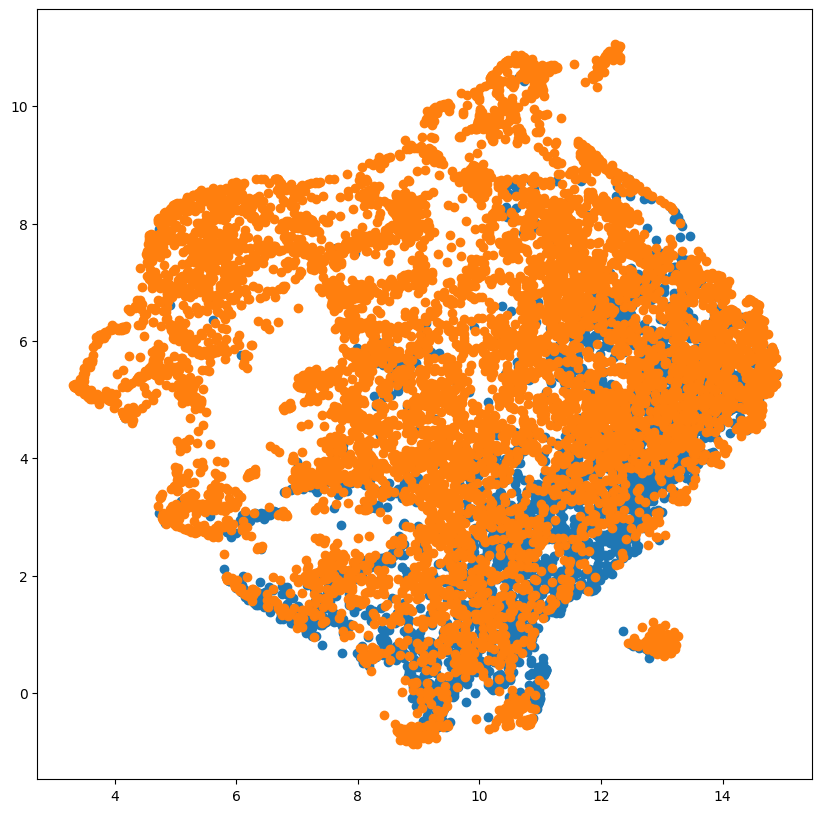

In [294]:
reducer = umap.UMAP(n_components=2)
X_train_umap = reducer.fit_transform(X_train_transformer_ptb)
visualize_umap(X_train_umap, y_train_transformer_ptb)

### CPC

In [298]:
cpc = CPC().to(device)
cpc.load_state_dict(torch.load('./p2/models/cpc_mit_100_best.pth'))

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

#### MIT data

In [301]:
X_train_cpc_mit = []
y_train_cpc_mit = []

X_test_cpc_mit = []
y_test_cpc_mit = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
        outputs, _ = cpc.encode(X_batch)
        X_train_cpc_mit.append(outputs)
        y_train_cpc_mit.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader):
        outputs, _ = cpc.encode(X_batch)
        X_test_cpc_mit.append(outputs)
        y_test_cpc_mit.append(y_batch)

X_train_cpc_mit = torch.cat(X_train_cpc_mit).cpu().numpy().squeeze()
X_test_cpc_mit = torch.cat(X_test_cpc_mit).cpu().numpy().squeeze()

y_train_cpc_mit = torch.cat(y_train_cpc_mit).cpu().numpy().squeeze()
y_test_cpc_mit = torch.cat(y_test_cpc_mit).cpu().numpy().squeeze()

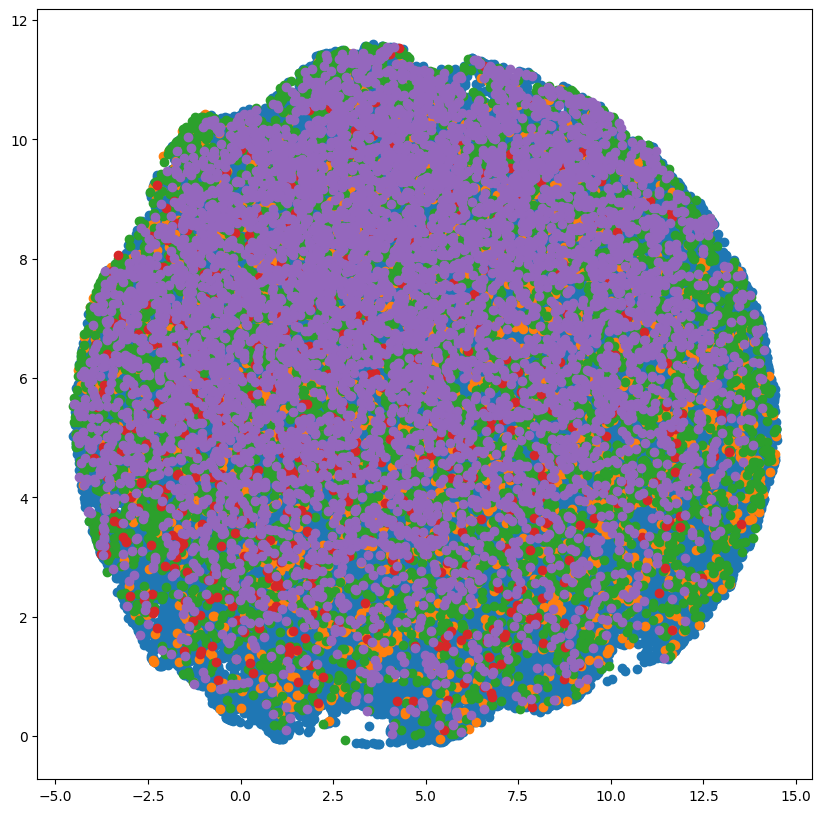

In [302]:
umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_cpc_mit)

visualize_umap(X_train_umap, y_train_cpc_mit)

#### PTB data

In [303]:
X_train_cpc_ptb = []
y_train_cpc_ptb = []
X_test_cpc_ptb = []
y_test_cpc_ptb = []

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(X_train_dataloader_ptb):
        outputs, _ = cpc.encode(X_batch)
        X_train_cpc_ptb.append(outputs)
        y_train_cpc_ptb.append(y_batch)

    for i, (X_batch, y_batch) in enumerate(X_test_dataloader_ptb):
        outputs, _ = cpc.encode(X_batch)
        X_test_cpc_ptb.append(outputs)
        y_test_cpc_ptb.append(y_batch)

X_train_encoder_ptb = torch.cat(X_train_cpc_ptb).cpu().numpy().squeeze()
X_test_encoder_ptb = torch.cat(X_test_cpc_ptb).cpu().numpy().squeeze()

y_train_encoder_ptb = torch.cat(y_train_cpc_ptb).cpu().numpy().squeeze()
y_test_encoder_ptb = torch.cat(y_test_cpc_ptb).cpu().numpy().squeeze()

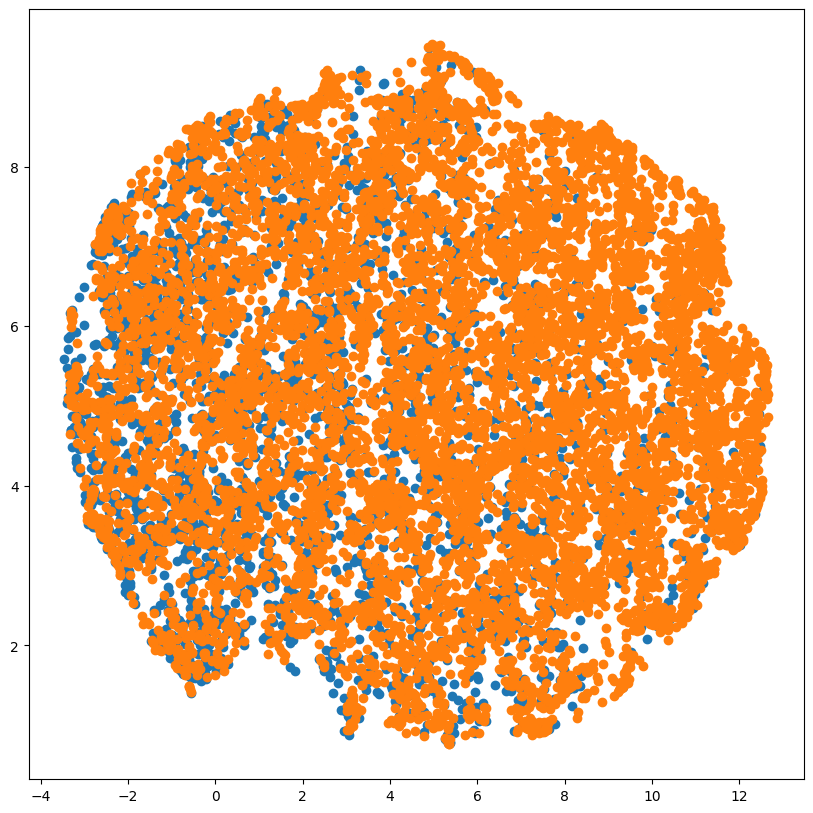

In [304]:
umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoder_ptb)

visualize_umap(X_train_umap, y_train_encoder_ptb)

## Finetuning Strategies

### Classic ML method

In [149]:
classifier = RandomForestClassifier()
classifier.fit(X_train_encoder_ptb, y_train_encoder_ptb)
y_pred = classifier.predict(X_test_encoder_ptb)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoder_ptb, y_pred):.4f}')

Test set balanced accuracy: 0.7535


### MLP output layers

In [390]:
def train_model(model, model_name, criterion, optimizer, X_train_dataloader, X_test_tensor, y_test_tensor, num_epochs, truncate, ret_weights=False):
    epoch_losses_training = []
    epoch_losses_testing = []
    epoch_accuracies_training = []
    epoch_accuracies_testing = []
    
    best_test_accuracy = 0

    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        total_loss = 0
        acc = []

        for i, (X_batch, y_batch) in enumerate(X_train_dataloader):
            if truncate:
                max_seq_len = (X_batch != 0).sum(dim=1).max().item()
                X_batch = X_batch[:, :max_seq_len, :]
            
            if ret_weights:
                outputs, _ = model(X_batch)
            else:
                outputs = model(X_batch)
                
            loss = criterion(outputs, y_batch)
            acc.append((outputs > 0.5).int() == y_batch)

            total_loss += loss.item() * len(X_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

        epoch_accuracies_training.append(torch.cat(acc).cpu().float().mean())
        epoch_losses_training.append(total_loss/len(X_train_tensor))

        with torch.no_grad():
            if ret_weights:
                output_test, _ = model(X_test_tensor)
            else:
                output_test = model(X_test_tensor)
                
            loss_test = criterion(output_test, y_test_tensor)
            epoch_losses_testing.append(loss_test.item())

            test_outputs = (output_test > 0.5).int()
            epoch_accuracies_testing.append(balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), test_outputs.cpu().numpy()))

            pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses_training[-1]:.4f}, Balanced Accuracy: {epoch_accuracies_training[-1]:.4f}, Test Loss: {epoch_losses_testing[-1]:.4f}, Test Balanced Accuracy: {epoch_accuracies_testing[-1]:.4f}')
            
        if epoch_accuracies_testing[-1] > best_test_accuracy:
            best_test_accuracy = epoch_accuracies_testing[-1]
            torch.save(model.state_dict(), f'./p2/models/{model_name}_{num_epochs}.pth')
        
        with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
            pickle.dump((epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing), f)

In [391]:
def plot_acc_and_loss(model_name, num_epochs, plot=True):
    
    with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', "rb") as f:
        while True:
            try:
                epoch_losses_training, epoch_losses_testing, epoch_accuracies_training, epoch_accuracies_testing = pickle.load(f)
            except EOFError:
                break
    
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    
        # Plotting the losses
        axs[0].plot(epoch_losses_training, label='Training Loss')
        axs[0].plot(epoch_losses_testing, label='Testing Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        
        # Plotting the accuracies
        axs[1].plot(epoch_accuracies_training, label='Training Accuracy')
        axs[1].plot(epoch_accuracies_testing, label='Testing Balanced Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        
        plt.tight_layout()
        plt.show()

In [392]:
def print_model_summary(model, criterion, X_test_tensor, y_test_tensor, ret_weights=False):
    print(model)
    print('Number of parameters: ' + str(sum(p.numel() for p in model.parameters() if p.requires_grad)))
    
    with torch.no_grad():
        if ret_weights:
            outputs, _ = model(X_test_tensor)
        else:
            outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor)
        outputs = (outputs > 0.5).float()
        accuracy = (outputs == y_test_tensor).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}, Loss: {loss.item():.4f}, Balanced Accuracy: {balanced_accuracy_score(y_test_tensor.int().cpu().numpy(), outputs.cpu().numpy())}')

In [393]:
class FinetunedModel(nn.Module):
    def __init__(self):
        super(FinetunedModel, self).__init__()
        self.encoder = CPC().to(device)
        self.encoder.load_state_dict(torch.load('./p2/models/cpc_mit_100_best.pth'))
        self.fc_out = nn.LazyLinear(1)

    def forward(self, x):
        output, _ = self.encoder.encode(x)
        output = self.fc_out(output)
        return output.squeeze()

#### Training of output layer only

In [374]:
finetuned_model_1 = FinetunedModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_1.parameters(), lr=3e-4)

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [375]:
num_epochs = 50

for name, param in finetuned_model_1.named_parameters():
    if 'fc_out' not in name:
        param.requires_grad = False

model_name = 'finetuned_model_1'
train_model(finetuned_model_1, model_name, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [50/50], Loss: 0.0779, Balanced Accuracy: 0.7219, Test Loss: 0.5856, Test Balanced Accuracy: 0.5000: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


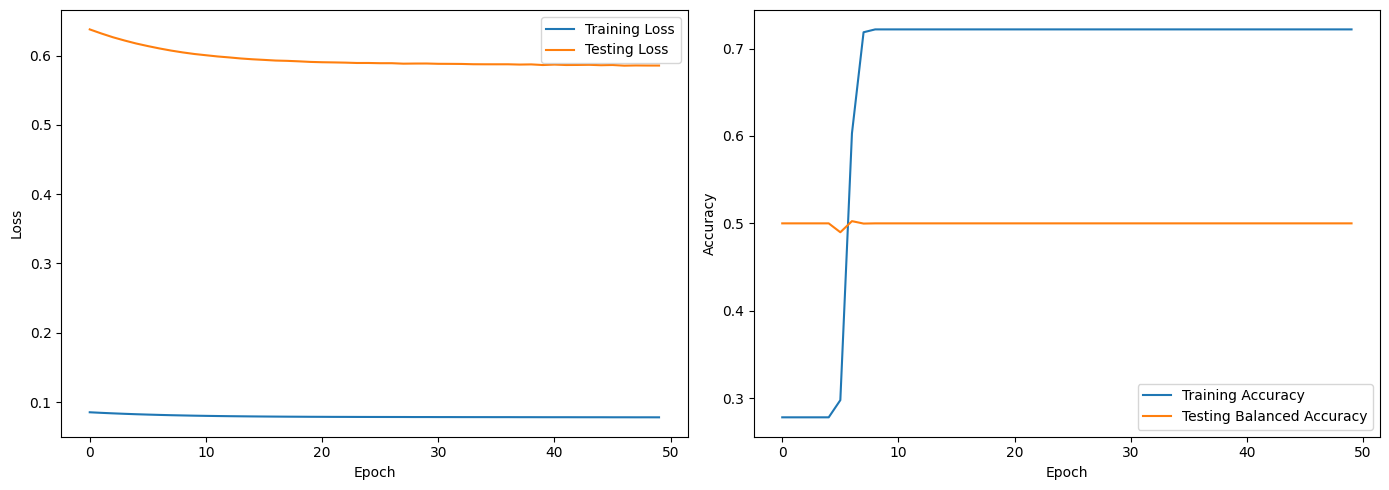

In [376]:
plot_acc_and_loss(model_name, num_epochs)

In [389]:
print_model_summary(finetuned_model_1, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): CPC(
    (encoder): TransformerModel(
      (embedding): Linear(in_features=187, out_features=128, bias=True)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )


#### Training of entire model

In [377]:
finetuned_model_2 = FinetunedModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_2.parameters(), lr=3e-4)

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [378]:
num_epochs = 50
model_name = 'finetuned_model_2'
train_model(finetuned_model_2, model_name, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [50/50], Loss: 0.0167, Balanced Accuracy: 0.9637, Test Loss: 0.1888, Test Balanced Accuracy: 0.9232: 100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


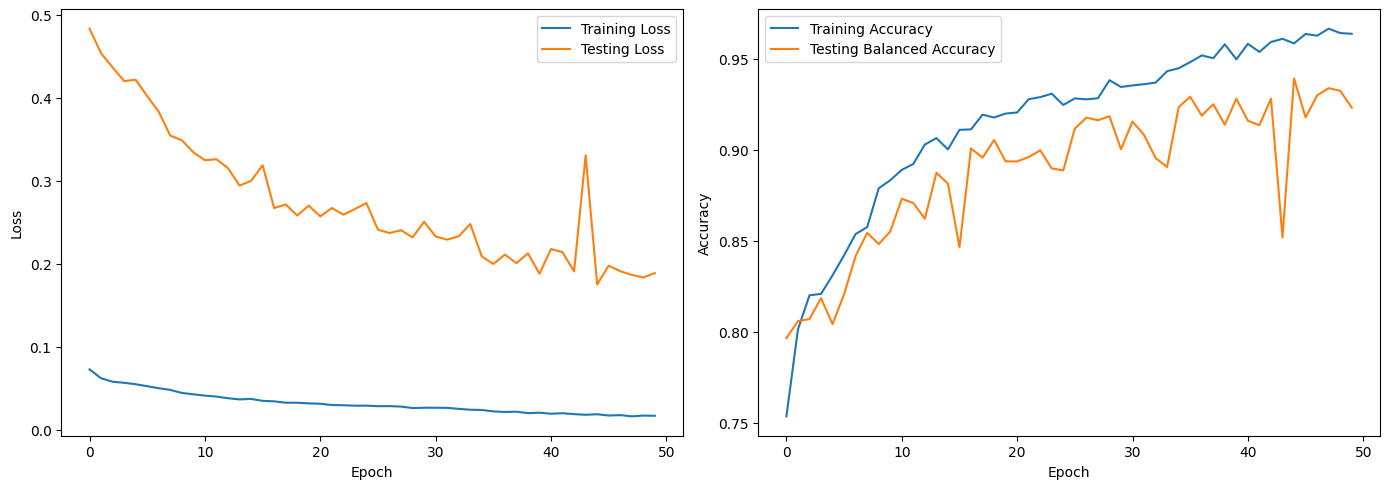

In [379]:
plot_acc_and_loss(model_name, num_epochs)

In [388]:
print_model_summary(finetuned_model_2, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): CPC(
    (encoder): TransformerModel(
      (embedding): Linear(in_features=187, out_features=128, bias=True)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )


#### 2-stage training

In [394]:
finetuned_model_3 = FinetunedModel().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(finetuned_model_3.parameters(), lr=3e-4)

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester02/02ML4HC/Projects/Project 2/venv/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [395]:
num_epochs = 50

for name, param in finetuned_model_3.named_parameters():
    if 'fc_out' not in name:
        param.requires_grad = False

model_name_a = 'finetuned_model_3a'
train_model(finetuned_model_3, model_name_a, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

for name, param in finetuned_model_3.named_parameters():
    param.requires_grad = True
    
model_name_b = 'finetuned_model_3b'
train_model(finetuned_model_3, model_name_b, criterion, optimizer, X_train_dataloader_ptb, X_test_tensor_ptb, y_test_tensor_ptb, num_epochs=num_epochs, truncate=False, ret_weights=False)

Epoch [50/50], Loss: 0.0785, Balanced Accuracy: 0.7219, Test Loss: 0.5895, Test Balanced Accuracy: 0.5000: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s]
Epoch [50/50], Loss: 0.0059, Balanced Accuracy: 0.9858, Test Loss: 0.2181, Test Balanced Accuracy: 0.9119: 100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


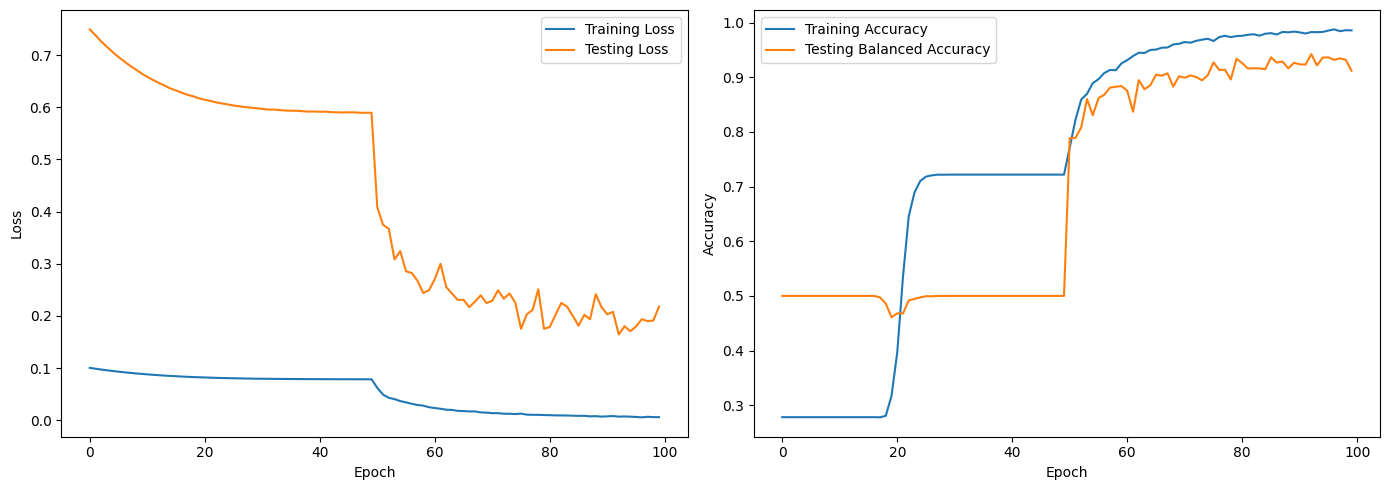

In [396]:
with open(f'./p2/eval/eval_{model_name_a}_{num_epochs}.pkl', "rb") as f:
    while True:
        try:
            epoch_losses_training_a, epoch_losses_testing_a, epoch_accuracies_training_a, epoch_accuracies_testing_a = pickle.load(f)
        except EOFError:
            break

with open(f'./p2/eval/eval_{model_name_b}_{num_epochs}.pkl', "rb") as f:
    while True:
        try:
            epoch_losses_training_b, epoch_losses_testing_b, epoch_accuracies_training_b, epoch_accuracies_testing_b = pickle.load(f)
        except EOFError:
            break
            
with open(f'./p2/eval/eval_{model_name}_{num_epochs}.pkl', 'wb') as f:
            pickle.dump((epoch_losses_training_a + epoch_losses_training_b, epoch_losses_testing_a + epoch_losses_testing_b, epoch_accuracies_training_a + epoch_accuracies_training_b, epoch_accuracies_testing_a + epoch_accuracies_testing_b), f)

model_name = 'finetuned_model_3'
plot_acc_and_loss(model_name, num_epochs)

In [397]:
print_model_summary(finetuned_model_3, criterion, X_test_tensor_ptb, y_test_tensor_ptb, ret_weights=False)

FinetunedModel(
  (encoder): CPC(
    (encoder): TransformerModel(
      (embedding): Linear(in_features=187, out_features=128, bias=True)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer_encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
            )
            (linear1): Linear(in_features=128, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=128, bias=True)
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )


# Old code below

In [150]:
logistic = LogisticRegression(max_iter=1000)

logistic.fit(X_train_transformer_ptb, y_train_transformer_ptb)

y_pred = logistic.predict(X_test_transformer_ptb)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_transformer_ptb, y_pred):.4f}')

Test set balanced accuracy: 0.7258


#### Encoder

In [151]:
logistic = LogisticRegression(max_iter=1000)

logistic.fit(X_train_encoder, y_train_encoder)

y_pred = logistic.predict(X_test_encoder)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoder, y_pred):.4f}')

Test set balanced accuracy: 0.2027


In [152]:
logistic = LogisticRegression(max_iter=1000)

logistic.fit(X_train_encoder_ptb, y_train_encoder_ptb)

y_pred = logistic.predict(X_test_encoder_ptb)
print(f'Test set balanced accuracy: {balanced_accuracy_score(y_test_encoder_ptb, y_pred):.4f}')

Test set balanced accuracy: 0.5415


### Fine-tune output layer only

### Fine-tune output layer, then fine-tune full model

#### old

In [435]:
class ContrastiveModel(nn.Module):
    def __init__(self, input_size, d_model=128, max_k=20):
        super(ContrastiveModel, self).__init__()

        self.d_model = d_model

        self.encoder = TransformerModel(input_size, d_model)

        # W[k,:,:] corresponds to W_k from the paper
        self.W = nn.Parameter(torch.randn(max_k, d_model, d_model))

        # This dumb linear layer calculates the value z_{t+k} from the paper
        # It feels weird to map a one dimensional value to 128 dimensions, but I think we can't really work in one dimension
        self.z_encoder = nn.Sequential(nn.Linear(1, d_model), nn.ReLU(), nn.Linear(d_model, d_model))

    def encode(self, src):
        return self.encoder(src)

    def forward(self, src, y_pos, y_neg, k):
        batch_size = src.shape[0]

        c = self.encoder(src)

        z_pos = self.z_encoder(y_pos.unsqueeze(1))
        z_neg = self.z_encoder(y_neg.flatten().unsqueeze(1)).view(batch_size, -1, self.d_model)
        # CrossEntropyLoss does not need any activation function in the output layer
        return c, z_pos, z_neg, self.W[k, :, :]

In [436]:
class InfoNCELoss(nn.Module):
    def __init__(self, temperature=1.0):
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, c, z_pos, z_neg, W_k):
        pred_k = torch.matmul(W_k, c.permute(1, 0))

        # score corresponds to f in the paper
        log_score_pos = torch.matmul(z_pos, pred_k).diag() / self.temperature
        log_score_neg = torch.diagonal(torch.matmul(z_neg, pred_k), dim1=0, dim2=2).permute(1, 0) / self.temperature

        log_score = torch.cat([log_score_pos.unsqueeze(1), log_score_neg], dim=1)

        normalizer = torch.logsumexp(log_score, dim=1)

        return (-log_score_pos + normalizer).mean()

In [ ]:
num_negative = 10
max_k = 7

In [114]:
train_dataloader_nce = DataLoader(torch.utils.data.TensorDataset(X_train_tensor[:-1]), batch_size=32,
                                  collate_fn=collate_fn, shuffle=True)

In [116]:
input_size = X_train_tensor.shape[1]
d_model = 128

model = ContrastiveModel(input_size, d_model, max_k).to(device)
criterion = InfoNCELoss(temperature=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

/Users/kari/ETH/vor2324/Machine Learning in Health Care/ML4HC_project2/mlhc2/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
epoch_losses_training = []

In [118]:
# This function can be trained on the checkpointed model to further try to improve the encoding, it is quite slow though.
num_epochs = 100

pbar = tqdm(range(num_epochs))

for epoch in pbar:
    total_loss = 0
    pred_train = []
    y_train_list = []

    for i, (X_batch, y_pos, y_neg, k) in enumerate(train_dataloader_nce):
        c, z_pos, z_neg, W_k = model(X_batch, y_pos, y_neg, k)

        loss = criterion(c, z_pos, z_neg, W_k)

        total_loss += loss.item() * len(X_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_losses_training.append(total_loss / len(X_train_tensor))

    with torch.no_grad():
        pbar.set_description(f'Epoch [{epoch + 1}/{num_epochs}], training loss: {epoch_losses_training[-1]:.4f}')

Epoch [57/100], training loss: 1.5977:  57%|█████▋    | 57/100 [1:56:49<1:28:07, 122.98s/it]


KeyboardInterrupt: 

In [119]:
torch.save(model.state_dict(), './p2/contrastive_57')

In [ ]:
with open('p2/contrastive_57_losses.pkl', 'wb') as f:
    pickle.dump((epoch_losses_training), f)

In [2]:
with open('p2/contrastive_57_losses.pkl', 'rb') as f:
    epoch_losses_training = pickle.load(f)

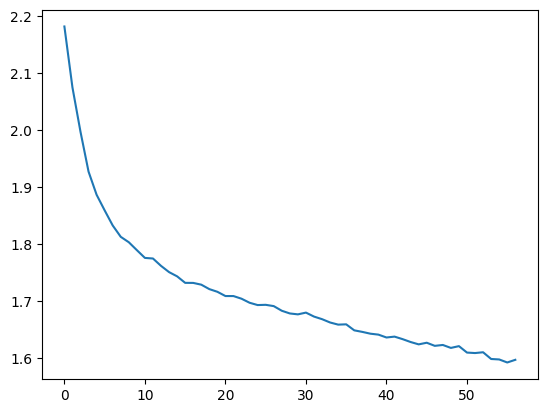

In [6]:
plt.plot(epoch_losses_training, label='Training Loss')
plt.show()